In [281]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import seaborn as sns
import os 

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

# %matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [207]:
# os.makedirs('csv', exist_ok=True)
data_dir = 'data'

In [208]:
chain = 'Avalanche' # Arbitrum

In [209]:
fnames = {'fees': 'Fees_2022-01-06_2022-06-25.csv',
          'prices': 'Glp Price Comparison_2022-01-06_2022-06-25.csv', 
          'open_interest': 'Open Interest_2022-01-06_2022-06-25.csv',
          'volume': 'Volume_2022-01-06_2022-06-25.csv',
         }

## Prep Data

In [210]:
# read data
df_fees = pd.read_csv(os.path.join(data_dir, chain, fnames['fees']))
df_prices = pd.read_csv(os.path.join(data_dir, chain, fnames['prices']))
df_oi = (pd.read_csv(os.path.join(data_dir, chain, fnames['open_interest']))
           .assign(short_to_long = lambda x: x.Short/x.Long))
df_volume = pd.read_csv(os.path.join(data_dir, chain, fnames['volume']))

In [211]:
# merge useful fields into one frame for modeling glp price (after fees)
df = (df_fees[['Date', 'Cumulative']].rename(columns={'Cumulative':'fees'})
          .merge(df_prices[['Date', 'glpPrice', 'glpPlusFees', 'lpBtcPrice', 'lpEthPrice']])
          .merge(df_oi[['Date', 'short_to_long']])
          .merge(df_volume[['Date', 'Cumulative']].rename(columns={'Cumulative':'volume'}))
     ).rename(columns={'Date':'date', 
                       'glpPrice':'glp_price',
                       'glpPlusFees':'glp_plusfees_price', 
                       'lpBtcPrice':'btc_price', # TBD: replace with tradingview data
                       'lpEthPrice':'eth_price', # TBD: replace with tradingview data
                      })

In [212]:
# use date as index
df['date'] = pd.to_datetime(df.date)
df = df.set_index('date')

In [213]:
df.head()

,fees,glp_price,glp_plusfees_price,btc_price,eth_price,short_to_long,volume
date,,,,,,,
2022-01-06,"48,658.7544",1.1710,1.1710,1.1710,1.1710,0.0762,"15,254,797.8553"
2022-01-07,"74,120.8528",1.1558,1.1570,1.1479,1.1336,0.1535,"34,871,269.1241"
2022-01-08,"103,506.5272",1.1452,1.1476,1.1511,1.1156,1.3266,"57,623,888.8122"
2022-01-09,"201,934.5933",1.1532,1.1594,1.1525,1.1256,3.4171,"140,376,517.9862"
2022-01-10,"358,511.6260",1.1072,1.1189,1.1526,1.1130,1.3284,"274,088,061.3677"


In [214]:
price_cols = ['glp_price', 'glp_plusfees_price', 'btc_price', 'eth_price']

## Returns if held until today

In [215]:
def calc_ret_till_today(start_dt):
    # Given a start date, calculate total returns of GLP, BTC, and ETH if buy-n-hold until today
    
    glp_buy_price = df.loc[start_dt, 'glp_price'] # buy GLP at (lower) before-fee price cuz can't earn fees before owning GLP
    btc_buy_price = df.loc[start_dt, 'btc_price']
    eth_buy_price = df.loc[start_dt, 'eth_price']
        
    # calculate GLP, BTC, and ETH returns
    row = pd.DataFrame(
        dict(glp_tot_ret = (df.glp_plusfees_price[-1] - glp_buy_price) / glp_buy_price,
             btc_tot_ret = (df.btc_price[-1] - btc_buy_price) / btc_buy_price,
             eth_tot_ret = (df.eth_price[-1] - eth_buy_price) / eth_buy_price),
        index=[start_dt])
    row.index.name='start_date'
    return row

calc_ret_till_today(start_dt = df.index[3])

,glp_tot_ret,btc_tot_ret,eth_tot_ret
start_date,,,
2022-01-09,-0.2181,-0.2887,-0.3760


In [216]:
df_rets = pd.concat(calc_ret_till_today(start_dt) for start_dt in df.index[:-1])
df_rets.head()

,glp_tot_ret,btc_tot_ret,eth_tot_ret
start_date,,,
2022-01-06,-0.2299,-0.2999,-0.4002
2022-01-07,-0.2198,-0.2858,-0.3804
2022-01-08,-0.2125,-0.2878,-0.3704
2022-01-09,-0.2181,-0.2887,-0.3760
2022-01-10,-0.1855,-0.2888,-0.3689


In [217]:
# change to long format
ret_cols = ['glp_tot_ret', 'btc_tot_ret', 'eth_tot_ret']
df_rets_long = (
    df_rets.reset_index()
        .melt(id_vars='start_date', value_vars=ret_cols, var_name='asset', value_name='tot_ret')
        .assign(asset=lambda x: x.asset.str.replace('_tot_ret', '').str.upper())
)
df_rets_long.head()

,start_date,asset,tot_ret
0,2022-01-06,GLP,-0.2299
1,2022-01-07,GLP,-0.2198
2,2022-01-08,GLP,-0.2125
3,2022-01-09,GLP,-0.2181
4,2022-01-10,GLP,-0.1855


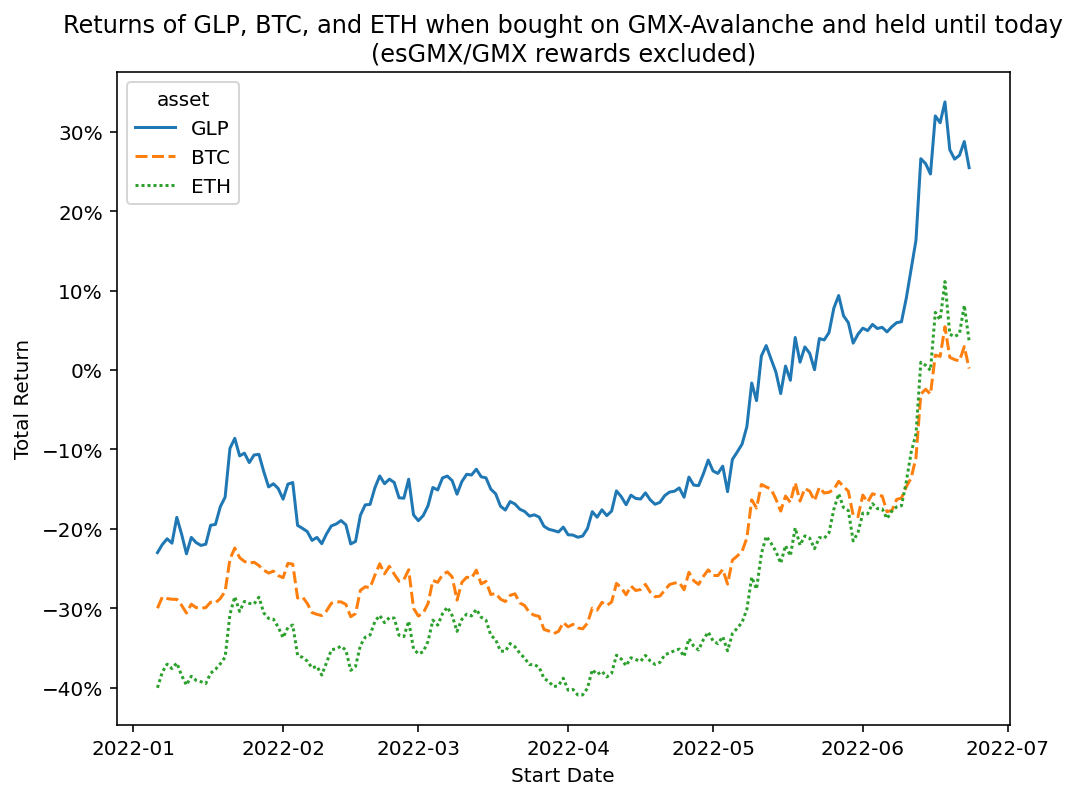

In [221]:
ax = sns.lineplot(data=df_rets_long, x='start_date', y="tot_ret", hue='asset', style='asset')
ax.set(xlabel='Start Date',
       ylabel='Total Return',
       title='Returns of GLP, BTC, and ETH when bought on GMX-{} and held until today\n(esGMX/GMX rewards excluded)'.format(chain)
      )
ax.yaxis.set_major_formatter(PercentFormatter(1))

- owning GLP has beaten BTC or ETH, even without considering GMX/esGMX rewards, regardless of the entry date
- this is because GLP has 50%+ in stablecoins and GLP holders receive 70% of the platform fees, and
- the platform has been generating lots of fees

## How much cash flow does GMX generate? 

In [289]:
fees_per_milvolume = df.fees/df.volume * 1e6

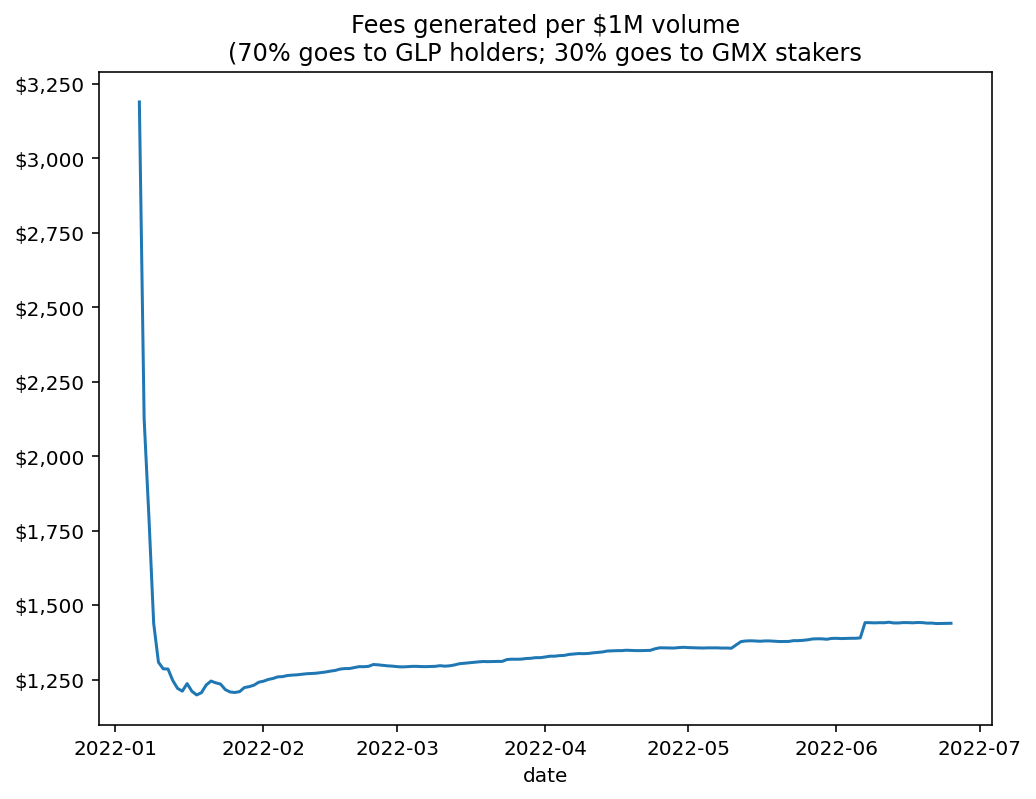

In [290]:
ax = sns.lineplot(data=fees_per_milvolume)
fmt = '${x:,.0f}' # dollar format
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.set(title="Fees generated per $1M volume\n(70% goes to GLP holders; 30% goes to GMX stakers");

In [291]:
fees_per_milvolume.head()

date
2022-01-06   3,189.7345
2022-01-07   2,125.5565
2022-01-08   1,796.2434
2022-01-09   1,438.5212
2022-01-10   1,308.0162
dtype: float64

Let's consider the first four days outliers because the small transaction volumes on those days were mostly due to shop opening. Let's drop them. 

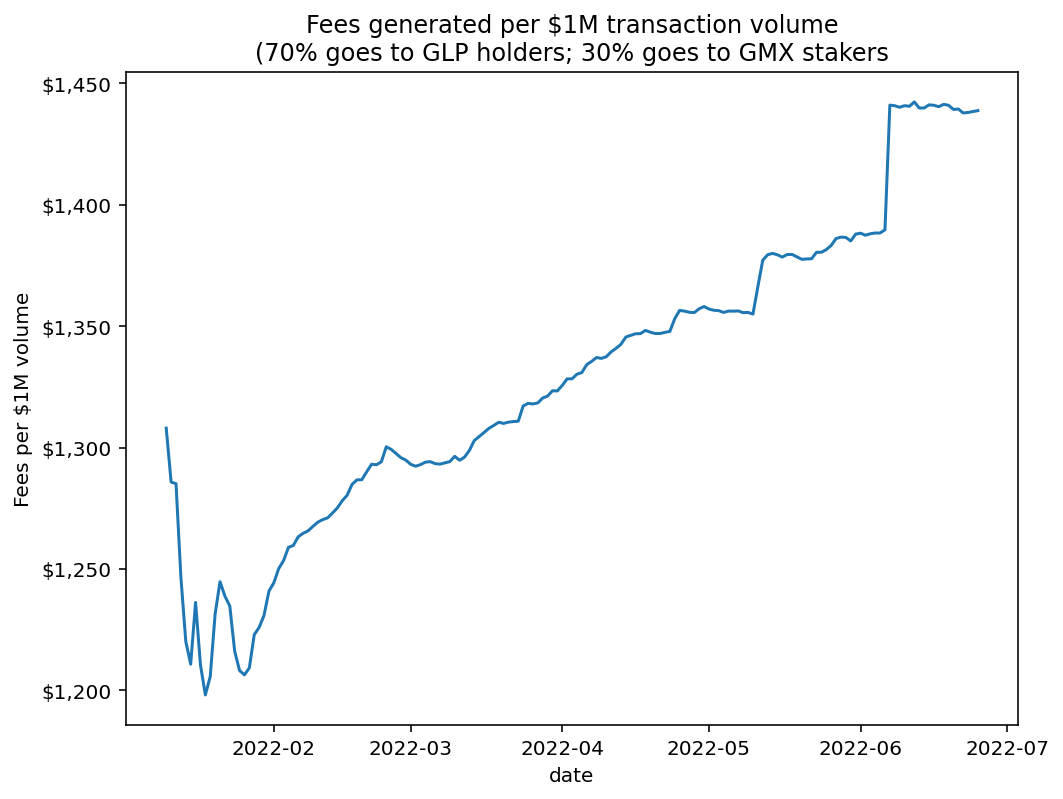

In [305]:
ax = sns.lineplot(data=fees_per_milvolume[4:])
fmt = '${x:,.0f}' # dollar format
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.set(title="Fees generated per $1M transaction volume\n(70% goes to GLP holders; 30% goes to GMX stakers",
       ylabel='Fees per $1M volume');

Fees, on a unit volume basis, was growing steadily during the first half of 2022, and reached the peak after June 07 as we entered the bear market.

In [315]:
avg = np.mean(fees_per_milvolume[4:])
ste = st.sem(fees_per_milvolume[4:], ddof=0) # same as std / sqrt(n), do not use the default ddof=1
ci99 = st.norm.interval(alpha=.99, loc=avg, scale=ste)
print("GXM generates an average of ${:.0f} per $1M transaction volume with a 99% confidence interval of (${:.0f}, ${:.0f}).".format(avg, ci99[0], ci99[1]))
print("${:.0f} goes to GLP holders, and ${:.0f} goes to GMX stakers.".format(avg*.7, avg*.3))

GXM generates an average of $1328 per $1M transaction volume with a 99% confidence interval of ($1316, $1341).
$930 goes to GLP holders, and $398 goes to GMX stakers.


## Model (fees adjusted) GLP Price 

In [321]:
dat = (df.assign(fees_per_1000dvolume = lambda x: x.fees / x.volume)
         .loc[:, ['glp_price', 'fees_per_1000dvolume', 'short_to_long']] 
      )
dat.head()

,glp_price,fees_per_1000dvolume,short_to_long
date,,,
2022-01-06,1.1710,0.0032,0.0762
2022-01-07,1.1558,0.0021,0.1535
2022-01-08,1.1452,0.0018,1.3266
2022-01-09,1.1532,0.0014,3.4171
2022-01-10,1.1072,0.0013,1.3284


In [324]:
# shift by 1, use yesterday to predict today

# sns.scatterplot(data=dat, x='short_to_long', y='glp_price')

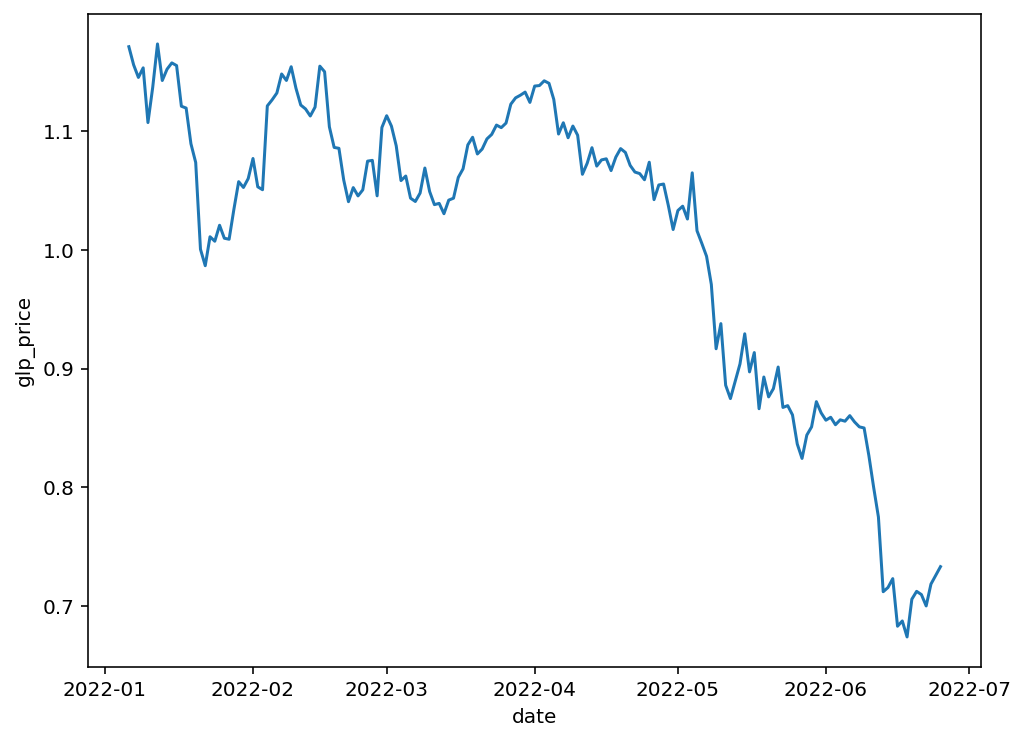

In [325]:
sns.lineplot(data=dat, x=dat.index, y='glp_price');